## **CÓDIGO ORIGINAL** (MANIPULAR CÓDIGO)





In [ ]:
###################################################################
# Fotometría de imágenes IRAC/SPITZER                             #
# Andrés Felipe Caro Mejía & Giovanni Pinzon                      #
###################################################################

# Librerias
# **photutlis 1.3.0** ; **astropy 4.3.1**

# INPUT : (1) Directorio en donde se encuentran las imagenes, calibradas
#             astrométricamente lin(27)
#             (https://nova.astrometry.net/upload)
#         (2) Catálogo RA DEC ID "catgaia" lin(51)
#         (3) Ruta Archivos de Salida *csv conteniendo la fotometría lin (354)
#         (4) Carga de catalogo landolt lin(359)
#         (5) Ruta a los archivos *csv lin(375)
#         (6) Parámetros fotométricos lin(254-57)


# OUTPUT : Archivos de texto plano *csv

# De ser necesario, instalar la librería Photutils
# pip install Photutils

# INICIO DEL PROGRAMA #
Center_box_size = 7

In [ ]:
# Carga del catálogo con coordenadas e identificador :  RA DEC ID
# FORMATO DEBE ESTAR EN: RA - DEC - ID
import numpy as np
archivo_catalogo = "/content/drive/MyDrive/Colab Notebooks/IC348S/cat"

catalogo = open(archivo_catalogo,"r")
objects = catalogo.readlines()
catalogo.close()


# Se organiza el catalogo como una lista ordenada
L_O = []
for i in objects:
  L_O.append(i.split())
listObjects = L_O

# Como el formato del catalogo es hhmmss ggmmss lo pasamos a grados decimales.
ra = [ i[0] for i in L_O ]
dec = [ i[1] for i in L_O ]
id = [ i[2] for i in L_O ]

In [ ]:
pip install photutils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.6 MB/s eta 0:00:00


In [ ]:
from astropy.coordinates import SkyCoord
from astropy import units as u
catalogo_decimal = SkyCoord(ra, dec, unit=( u.degree))
catalogo = list(zip(catalogo_decimal.ra.deg,catalogo_decimal.dec.deg,id))

# Fotometría de apertura usando Photutils + Objetos de catálogo
import numpy as np
from photutils.aperture import CircularAperture
from photutils.aperture import CircularAnnulus
from photutils.aperture import aperture_photometry
from photutils.utils import calc_total_error
from scipy.stats import mode
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def Photometry_Data_Table(fits_name, fits_path, catalogo, r, r_in, r_out, Center_box_size, *args):
  # Se abre el archivo .fits para guardarlo como una variable i.e. image / fits_data
  F = fits.open(fits_path)
  FitsData = F
  w = WCS(FitsData[0].header)
  fits_data = FitsData[0].data
  fits_header = FitsData[0].header
#print(w.array_shape)
#print(w.world_axis_physical_types)
 # airmass = fits_header['AIRMASS']
  itime  = fits_header['EXPTIME']
  ifilter = fits_header['CHNLNUM']
  DateObs = fits_header['DATE_OBS']
  target = fits_header['OBJECT']
  epadu = fits_header['GAIN']
  F.close()

  image=fits_data

# Funcion que ajusta los objetos del catalogo a solo aquellos que podrían estar en la imágen
  def is_in_pic(w, image, ra, dec):
    ra_max, dec_max = w.array_index_to_world_values(0,0)
    ra_min, dec_min = w.array_index_to_world_values(image.shape[0], image.shape[1])
    if ra_min > ra_max:
      ra_min = w.array_index_to_world_values(0,0)[0]
      ra_max = w.array_index_to_world_values(image.shape[0], image.shape[1])[0]
    if dec_min > dec_max:
      dec_min = w.array_index_to_world_values(0,0)[1]
      dec_max = w.array_index_to_world_values(image.shape[0], image.shape[1])[1]

    return (ra < ra_max) & (ra > ra_min) & (dec < dec_max) & (dec >   dec_min)
  NewListO = open(f"Objectlist_{fits_name}.out", "w")
  # Contador de objetos de catálogo que están en la imágen
  object_counter = 0
  for j in range(0,len(catalogo)):
    condicion = is_in_pic(w, image, catalogo[j][0],    catalogo[j][1])
    if condicion:
      object_counter +=1
      X, Y = SkyCoord(catalogo[j][0], catalogo[j][1], frame="icrs", unit="deg").to_pixel(w)
      NewListO.write(f"{catalogo[j][0]}     {catalogo[j][1]}     {catalogo[j][2]}   {X}   {Y}   {condicion}\n")
  NewListO.close()
  print(f'\n Se han encontrado {object_counter} objetos del catalogo en el archivo .fits \n')

  if object_counter == 0:
    return None
    quit()

# Se guardan las coordenadas de los objetos de catálogo que están en la imágen
  Obj = open(f"Objectlist_{fits_name}.out", "r")
  ListObj = Obj.readlines()
  Obj.close()
  Final_LO = []
  for i in ListObj:
    Final_LO.append(i.split()[:5])
  RA, DEC, ID, x, y = zip(*Final_LO)
  Final_List = np.array(list(zip(RA,DEC,x,y)), dtype=float)
  ID = np.array(ID,dtype='U20')

  # Eliminar los objetos que no esten en el archivo fits (en caso de que la funcion is_in_pic() haya fallado numericamente)
  mm = [ 0 < i[2] and i[2] < (image.shape[0] - 1) for i in Final_List] # Lista de [Booleanos] (x) en las cuales las posiciones si esten en la imagen
  ID = ID[mm]
  Final_List = Final_List[mm]
  nn = [ 0 < i[3] and i[3] < (image.shape[1] - 1) for i in Final_List] # Lista de [Booleanos] (y) en las cuales las posiciones si esten en la imagen
  ID = ID[nn]
  Final_List = Final_List[nn]

# IDs repetidos se categorizan
  u, c = np.unique(ID, return_counts=True)
  dup = u[c > 1]
  for j in dup:
    m = 0
    for i in range(len(ID)):
      if ID[i] == j:
        m += 0.1
        ID[i] = ID[i] + str(m)

# Se imprime en consola una previsualizacion de como es el nuevo catalogo reducido.
  np.set_printoptions(suppress=True, formatter={'float_kind':'{:f}'    .format})
  print(f"\nSu catalogo reducido es (filas {len(Final_List)}):\n ")
  print("----RA---- ---DEC--- -----x-----  -----y----- -----ID-------\n")
  print(Final_List[0],ID[0])
  print("    ...       ...         ...          ...         ...        \n")
  print(Final_List[len(Final_List)-1],ID[len(Final_List)-1])
  print("---------- --------- ------------  ----------- -------------\n")

# Se extraen los valores X y Y
  _, _, x_init, y_init = zip(*Final_List)

  from photutils.centroids import centroid_sources, centroid_com
  x, y = centroid_sources(image, x_init, y_init, box_size = Center_box_size, centroid_func=centroid_com)
  X, Y = np.array(x), np.array(y)
  NewIDS = np.array(ID)

# Se eliminan los datos a los cuales tienen un centroide NaN o inf
  is_nan = ~np.isnan(X)
  x, y = X[is_nan],Y[is_nan]
  Final_List2 = Final_List[is_nan]
  NewIDS = NewIDS[is_nan]

# Centroides de coordenadas de las estrellas
  starloc = list(zip(x,y))
#print(starloc)
  if ifilter == 1:
    zmag =  18.8027
  elif ifilter == 2:
    zmag = 18.3177
  elif ifilter == 3:
    zmag =  17.8331
  elif ifilter == 4:
    zmag =  17.2120
  else:
    zmag = 17.2120
  print(zmag)



# Extracción señal de cada estrella
  aperture = CircularAperture(starloc, r=r)
  annulus_aperture = CircularAnnulus(starloc, r_in=r_in, r_out=r_out )
  apers = [aperture, annulus_aperture]
  # Se genera una tabla de datos.
  phot_table = aperture_photometry(image, apers)

  # Se le asigna nombre de la magnitud dependiendo del filtro en el encabezado
  name_mag = str(ifilter)

  # Area y fujo en los anillos.
  bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
  area_aper = np.array(aperture.area_overlap(image))
  bkg_sum = bkg_mean * area_aper

  # Flujo final para cada objeto
  final_sum = phot_table['aperture_sum_0'] - bkg_sum
  phot_table['flux'] = final_sum
  phot_table['flux'].info.format = '%.8g'

  # Magnitudes Instrumentales
  phot_table[name_mag + '_mag'] = zmag - 2.5 * np.log10(final_sum) + 2.5 * np.log10(itime)
  phot_table[name_mag + '_mag'].info.format = '%.8g'

  # Error de las Magnitudes Instrumentales
  from astropy.stats import sigma_clipped_stats
  mean, median, std = sigma_clipped_stats(image, sigma=3.0)
  stdev = std
  phot_table[name_mag + '_mag_err'] = 1.0857 * np.sqrt(final_sum    /epadu + area_aper*stdev**2 )/final_sum
  phot_table[name_mag + '_mag_err'].info.format = '%.8g'

  # Se agrega a la tabla la RA, DEC, ID y Masa de aire.
  phot_table['RA'] = [i[0] for i in Final_List2]
  phot_table['DEC'] = [i[1] for i in Final_List2]
  phot_table['ID'] = NewIDS
 # phot_table['AIRMASS'] = airmass
  phot_table['DATE-OBS'] = DateObs
 # phot_table['APERTURE'] = r
 # phot_table['Rint'] = r_in
 # phot_table['Rout'] = r_out
 # phot_table['AIRTEMP'] = ccdtemp
  phot_table['OBJECT'] = fits_header['OBJECT']
  # Se buscan los indices en donde las magnitudes sean NaN y se eliminan
  index_nan = np.argwhere(np.isnan(phot_table[name_mag + '_mag'].data))
  phot_table.remove_rows(index_nan)
  filas = len(phot_table)
  return phot_table

## **CÓDIGO EDITADO** (CREAR LAS TABLAS Y ESCOGER RADIO DE APERTURA)

In [ ]:
#No lo utilizo actualmente pero crea un arreglo con los archivos fits para los 4 canales.

Num_Archivos = 4

for i in range(1, Num_Archivos +1):
  carpeta = f'/content/drive/MyDrive/Colab Notebooks/Ch{i}/'
  archivos = glob.glob(carpeta + '*.fits')
  print(" Archivos Encontrados")
  nombres = []
  for j in archivos:
    if carpeta in j:
      nombres.append(j.replace(carpeta,''))
  if nombres != []:
    l = len(nombres)
    print(f'\n Su carpeta tiene {l} archivos .fits \n')
    print(f'No. 1: {nombres[0]}')
    print(f'          ....            ')
    print(f'No. {l}: {nombres[l-1]}')
  else:
    print('\n Su carpeta no tiene archivos .fits \n')

In [ ]:
#Crear 7 tablas (1 para cada valor de radio de apertura) por canal.

from astropy.table.table import QTable

Num_Archivos = 4

#########################################
# Definición de parámetros fotométricos #
#########################################
r = 10 #Apertura en px
r_in = 12 #Radio interno anillo cielo
r_out = 13 #Radio externo
#########################################

for num in range(1, Num_Archivos + 1):
  carpeta = f'/content/drive/MyDrive/Colab Notebooks/Ch{num}/'
  archivos = glob.glob(carpeta + '*.fits')

  if archivos:
    print(f"Archivos Encontrados")
    nombres = []
    for j in archivos:
      if carpeta in j:
        nombres.append(j.replace(carpeta, ''))

    l = len(nombres)
    print(f'Su carpeta tiene {l} archivos .fits')

    if l > 0:
      all_tables = []
      for k in range(len(archivos)):
        fits_path = archivos[k]
        fits_name = nombres[k]

        # Procesa cada archivo .fits como se hace en el código original
        photom = Photometry_Data_Table(fits_name, fits_path, catalogo, r=r, r_in=r_in, r_out=r_out, Center_box_size=Center_box_size)

        if photom is not None:
          all_tables.append(photom)

      print(f'Se tienen {len(all_tables)} tablas de las imágenes .fits \n\n')
      #----# Crea lista con los nombres de los objetos a los cuales se enfoca el telescopio
      focus_object = []
      for m in all_tables:

        #if m != []:
        ob = m['OBJECT'][0]

        if ob not in focus_object:
          focus_object.append(ob)   # Ejemplo: focus_object = ['SA98', 'SA95', '[BSA98', 'SA101', '[ASA98', 'SA104', 'SA92']

      #----#  Se crea diccionario con cada objeto de enfoque
      filtro_final = {}
      for s in focus_object:
        filtro_final[s] = []        # Ejemplo: filtro_final = {'SA98':[], 'SA95':[], '[BSA98':[], 'SA101':[], '[ASA98':[], 'SA104':[], 'SA92':[]}

      #----#  Se llena el diccionario
      for n in all_tables:
        for p in focus_object:
          ob = n['OBJECT'][0]
          if ob == p:
            filtro_final[ob].append(n.copy()) # Ejemplo: filtro_final = {'SA98':[tabla1,tabla2,tabla3,..], ... , 'SA92':[tabla1,tabla2,tabla3,..]}

      #----#  Para cada observacion de enfoque se hace la interseccion de los objetos que esten en los tres filtros
      for foc in focus_object:
        current_id = []
        for j in filtro_final[foc]:
          current_id.append(j['ID'].data)

        int_d = set(current_id[0]).intersection(*current_id) # Ejemplo para SA98: int_d = {'92_248', ... , '92_347'}

        #----# Se eliminan los objetos que no esten en los tres filtros
        for tab in filtro_final[foc]:
          index_of = []
          for i in range(len(tab['ID'])):
            if tab['ID'][i] not in int_d:
              index_of.append(i)
          tab.remove_rows(index_of)

        #----# Eliminar las tablas que esten vacias
        for p in focus_object:
          if len(filtro_final[p][0]) == 0:
            del filtro_final[p]

        #----# Se crean tablas para cada objeto de enfoque
        for foc in filtro_final.keys():
          let = len(filtro_final[foc])
          final_obs_table = QTable()
          final_obs_table['OBJECT_ID'] = filtro_final[foc][0]['ID']
          final_obs_table['RA'] = filtro_final[foc][0]['RA']
          final_obs_table['DEC'] = filtro_final[foc][0]['DEC']

          #----# Se guardan las tablas como archivos .csv
          counter = 0
          for j in filtro_final[foc]:


            final_obs_table[j.colnames[6] + '_' + str(counter // 3)] = j[j.colnames[6]]
            final_obs_table[j.colnames[7] + '_' + str(counter // 3)] = j[j.colnames[7]]
            final_obs_table[j.colnames[11] + '_' + j.colnames[6] + '_' + str(counter // 3)] = j[j.colnames[11]]
            counter += 1

          final_obs_table.write(f'/content/drive/MyDrive/Colab Notebooks/Ch{num}/Table_{foc}C{num}R{r}.csv', overwrite=True)
    else:
        print(f'\nSu carpeta {carpeta} no tiene archivos .fits\n')


# FIN DEL PROGRAMA #
# Observatorio Astronómico Nacional 2023 #

Archivos Encontrados
Su carpeta tiene 1 archivos .fits

 Se han encontrado 1312 objetos del catalogo en el archivo .fits 


Su catalogo reducido es (filas 995):
 
----RA---- ---DEC--- -----x-----  -----y----- -----ID-------

[56.299527 31.960415 725.902055 2458.991337] 216625574747216384
    ...       ...         ...          ...         ...        

[56.023281 32.325271 3120.585844 1445.358557] 216719243689547648
---------- --------- ------------  ----------- -------------

18.8027
Se tienen 1 tablas de las imágenes .fits 


Archivos Encontrados
Su carpeta tiene 1 archivos .fits

 Se han encontrado 1312 objetos del catalogo en el archivo .fits 


Su catalogo reducido es (filas 995):
 
----RA---- ---DEC--- -----x-----  -----y----- -----ID-------

[56.299527 31.960415 725.902055 2458.991337] 216625574747216384
    ...       ...         ...          ...         ...        

[56.023281 32.325271 3120.585844 1445.358557] 216719243689547648
---------- --------- ------------  ----------- ---

In [ ]:
#Imprime una de las tablas anteriores para verificar.

import pandas as pd
tabla = "/content/drive/MyDrive/Colab Notebooks/Ch1/Table_IC348C1R10.csv"
pd.read_csv(tabla)

,OBJECT_ID,RA,DEC,1_mag_0,1_mag_err_0,DATE-OBS_1_mag_0
0,216625574747216384,56.299527,31.960415,17.640757,0.177302,2009-03-19T05:12:51.935
1,216626300596227840,56.152185,31.904073,18.217886,0.277412,2009-03-19T05:12:51.935
2,216626300596413824,56.156387,31.905155,18.036906,0.240302,2009-03-19T05:12:51.935
3,216626438035274624,56.203215,31.909487,19.082125,0.569280,2009-03-19T05:12:51.935
4,216626541114351360,56.219511,31.915175,19.135271,0.595878,2009-03-19T05:12:51.935
...,...,...,...,...,...,...
938,216719312409023360,56.022659,32.331783,16.617141,0.087012,2009-03-19T05:12:51.935
939,216719273753784832,56.046041,32.328156,14.012105,0.021002,2009-03-19T05:12:51.935
940,216719239393516416,56.033585,32.328032,17.325829,0.140776,2009-03-19T05:12:51.935
941,216719308112822400,56.020875,32.334301,18.608277,0.381499,2009-03-19T05:12:51.935


In [ ]:
#Crea un arreglo con los nombres de las 7 tablas en un canal en específico para usar.

carpeta = f'/content/drive/MyDrive/Colab Notebooks/Ch1/'
archivos = glob.glob(carpeta + '*.csv')
print(" Archivos Encontrados")
nombres = []
for j in archivos:
  if carpeta in j:
    nombres.append(j.replace(carpeta,''))
  if nombres != []:
    l = len(nombres)
    print(f'\n Su carpeta tiene {l} archivos .csv \n')
    print(f'No. 1: {nombres[0]}')
    print(f'          ....            ')
    print(f'No. {l}: {nombres[l-1]}')
  else:
    print('\n Su carpeta no tiene archivos .csv \n')

print(f'\n \n {nombres}')

 Archivos Encontrados

 Su carpeta tiene 1 archivos .csv 

No. 1: Table_IC348C1R06.csv
          ....            
No. 1: Table_IC348C1R06.csv

 Su carpeta tiene 2 archivos .csv 

No. 1: Table_IC348C1R06.csv
          ....            
No. 2: Table_IC348C1R08.csv

 Su carpeta tiene 3 archivos .csv 

No. 1: Table_IC348C1R06.csv
          ....            
No. 3: Table_IC348C1R10.csv

 Su carpeta tiene 4 archivos .csv 

No. 1: Table_IC348C1R06.csv
          ....            
No. 4: Table_IC348C1R12.csv

 Su carpeta tiene 5 archivos .csv 

No. 1: Table_IC348C1R06.csv
          ....            
No. 5: Table_IC348C1R14.csv

 Su carpeta tiene 6 archivos .csv 

No. 1: Table_IC348C1R06.csv
          ....            
No. 6: Table_IC348C1R16.csv

 Su carpeta tiene 7 archivos .csv 

No. 1: Table_IC348C1R06.csv
          ....            
No. 7: Table_IC348C1R18.csv

 
 ['Table_IC348C1R06.csv', 'Table_IC348C1R08.csv', 'Table_IC348C1R10.csv', 'Table_IC348C1R12.csv', 'Table_IC348C1R14.csv', 'Table_IC348C

In [ ]:
'''
Toma la tabla de menor radio de apertura para el primer canal y escoge 10 estrellas aleatorias.

Barre tabla por tabla, de un canal en específico, y toma la columna de magnitud de cada tabla y la
anexa a una nueva tabla que contiene las magnitudes para cada valor de radio.
'''

from ast import Assign
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

PrimeraTabla = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Ch1/Table_IC348C1R06.csv')
columna_id = PrimeraTabla["OBJECT_ID"]

# Seleccionar 10 objetos aleatorios de la primera tabla
estrellas_aleatorias_desorden = columna_id.sample(n=10, random_state=5)
estrellas_aleatorias = estrellas_aleatorias_desorden.sort_index()

estrellas_aleatorias_tabla = pd.DataFrame()
estrellas_aleatorias_lista = []

#Va tabla por tabla escogiendo únicamente la información de las estrellas que tengan el mismo ID
for objeto in nombres:
    df = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/Ch1/{objeto}')

    data_estrellas = df[df["OBJECT_ID"].isin(estrellas_aleatorias)]  # Filtro usando "OBJECT_ID"
    magnitud_estrellas = data_estrellas['1_mag_0']
    estrellas_aleatorias_lista.append(magnitud_estrellas) #Lista magnitud de las estrellas

    mag_estrellas = magnitud_estrellas.to_numpy()
    estrellas_aleatorias_tabla[objeto] = mag_estrellas #Tabla magnitud de las estrellas

# print(estrellas_aleatorias_lista)
estrellas_aleatorias_tabla

,Table_IC348C1R06.csv,Table_IC348C1R08.csv,Table_IC348C1R10.csv,Table_IC348C1R12.csv,Table_IC348C1R14.csv,Table_IC348C1R16.csv,Table_IC348C1R18.csv
0,17.201320,17.172925,17.172386,17.113440,17.070078,17.104826,17.208087
1,14.436267,14.398027,14.377771,14.364943,14.352977,14.369053,14.620928
2,15.550843,15.530150,15.577206,15.626191,15.688697,15.777864,15.937563
3,14.744334,14.693586,14.666109,14.662226,14.694102,14.745585,14.738444
4,12.292797,12.250008,12.223884,12.203093,12.189770,12.181488,12.175683
5,17.449036,17.508640,17.570069,17.418185,17.267664,17.314696,17.230428
6,16.588559,16.565483,16.556816,16.567224,16.626169,16.836118,17.312878
7,16.734910,16.645690,16.562732,16.493791,16.455878,16.426774,16.427146
8,17.388176,16.872833,16.433317,16.040178,15.656304,15.370606,15.250221
9,14.908198,14.867368,14.835797,14.807092,14.807225,14.821287,14.799297


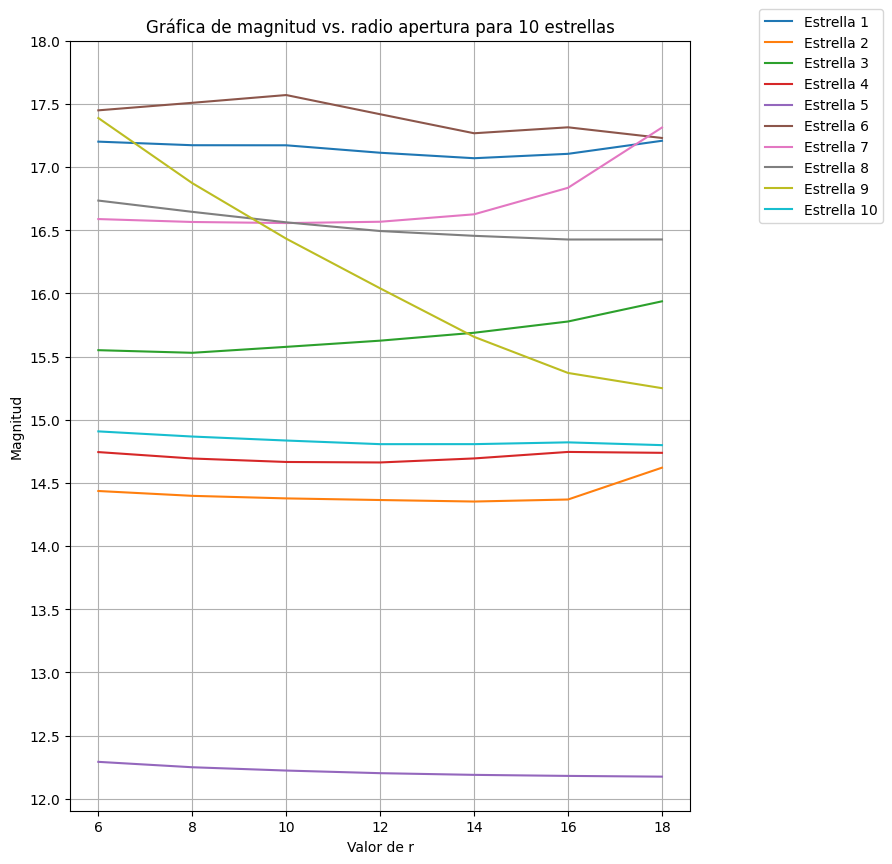

In [ ]:
#Toma cada fila de la tabla (las magnitudes vs radio) y las convierte en arreglos para graficar.

import matplotlib.pyplot as plt
radio = np.linspace(6, 18, 7)
plt.figure(figsize=(8, 10))

for estrella in estrellas_aleatorias_tabla.index:
    magnitudes = estrellas_aleatorias_tabla.loc[estrella].values

    plt.plot(radio, magnitudes, label=f'Estrella {estrella+1}')

plt.xlabel('Valor de r')
plt.ylabel('Magnitud')
plt.title('Gráfica de magnitud vs. radio apertura para 10 estrellas')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.grid(True)

num_tics = 13
y_max = 18
y_min = 12
plt.yticks(np.linspace(y_min, y_max, num_tics))

plt.show()

## **CÓDIGO ORIGINAL** (TABLAS FINALES RADIO DEFINIDO)


In [ ]:
'''
Una vez definido un radio de apertura para cada canal, se utiliza el código original para crear
las tablas finales que se usarán para el diagrama color-magnitud.
'''

# Directorio en donde se encuentran las imagenes fits
import glob
carpeta = '/content/drive/MyDrive/Colab Notebooks/IC348S/ch4/'

# Busqueda de los archivos .fits
archivos = glob.glob(carpeta + '*.fits')

# Impresion de los archivos encontados y guardado de nombre del archivo en lista
print(" Archivos Encontrados")
nombres = []
for j in archivos:
  if carpeta in j:
    nombres.append(j.replace(carpeta,''))

if nombres != []:
  l = len(nombres)
  print(f'\n Su carpeta tiene {l} archivos .fits \n')
  print(f'No. 1: {nombres[0]}')
  print(f'          ....            ')
  print(f'No. {l}: {nombres[l-1]}')
else:
  print('\n Su carpeta no tiene archivos .fits \n')

#########################################
# Definición de parámetros fotométricos #
#########################################
r = 6 #Apertura en px
r_in = 6 #Radio interno anillo cielo
r_out = 14 #Radio externo
#########################################
# Se imprime la tabla en un archivo de texto plano
all_tables = []
for k in range(len(archivos)):
  fits_path = archivos[k]
  fits_name = nombres[k]
#  catalogo = catalogo_final

  photom = Photometry_Data_Table(fits_name, fits_path, catalogo, r=r, r_in=r_in, r_out=r_out, Center_box_size=Center_box_size)
  if photom is not None:
    all_tables.append(photom)

print(f'Se tienen {len(all_tables)} tablas de las imagenes .fits')
#----# Crea lista con los nombres de los objetos a los cuales se enfoca el telescopio
focus_object = []
for m in all_tables:

 #if m != []:
  ob = m['OBJECT'][0]

  if ob not in focus_object:

    focus_object.append(ob)   # Ejemplo: focus_object = ['SA98', 'SA95', '[BSA98', 'SA101', '[ASA98', 'SA104', 'SA92']

#----#  Se crea diccionario con cada objeto de enfoque
filtro_final = {}
for s in focus_object:
  filtro_final[s] = []        # Ejemplo: filtro_final = {'SA98':[], 'SA95':[], '[BSA98':[], 'SA101':[], '[ASA98':[], 'SA104':[], 'SA92':[]}

#----#  Se llena el diccionario
for n in all_tables:
  for p in focus_object:
    ob = n['OBJECT'][0]
    if ob == p:
      filtro_final[ob].append(n.copy())  # Ejemplo: filtro_final = {'SA98':[tabla1,tabla2,tabla3,..], ... , 'SA92':[tabla1,tabla2,tabla3,..]}

#----#  Para cada observacion de enfoque se hace la interseccion de los objetos que esten en los tres filtros
for foc in focus_object:
  current_id = []
  for j in filtro_final[foc]:
    current_id.append(j['ID'].data)

  int_d = set(current_id[0]).intersection(*current_id) # Ejemplo para SA98: int_d = {'92_248', ... , '92_347'}

  #----# Se eliminan los objetos que no esten en los tres filtros
  for tab in filtro_final[foc]:
    index_of = []
    for i in range(len(tab['ID'])):
      if tab['ID'][i] not in int_d:
        index_of.append(i)
    tab.remove_rows(index_of)

#----# Eliminar las tablas que esten vacias
for p in focus_object:
  if len(filtro_final[p][0]) == 0:
    del filtro_final[p]

for foc in filtro_final.keys():
  let = len(filtro_final[foc])


from astropy.table.table import QTable

# noche = input('Ingrese la noche en que hizo la fotometria')
noche = 'N3'
''
#----# Se crean tablas para cada objeto de enfoque
for foc in filtro_final.keys():
  final_obs_table = QTable()
  final_obs_table['OBJECT_ID'] = filtro_final[foc][0]['ID']
  final_obs_table['RA'] = filtro_final[foc][0]['RA']
  final_obs_table['DEC'] = filtro_final[foc][0]['DEC']

#----# Se guardan las tablas como archivos .csv
  counter = 0
  for j in filtro_final[foc]:


    final_obs_table[j.colnames[6] + '_' + str(counter//3)] = j[j.colnames[6]]
    final_obs_table[j.colnames[7] + '_' + str(counter//3)] = j[j.colnames[7]]
    final_obs_table[j.colnames[11] + '_' + j.colnames[6] + '_' + str(counter//3)] = j[j.colnames[11]]
    counter += 1
  final_obs_table.write(f'/content/drive/MyDrive/Colab Notebooks/IC348S/ch4/Table_{foc}C4R06FINAL.csv', overwrite=True)




# FIN DEL PROGRAMA #
# Observatorio Astronómico Nacional 2023 #

 Archivos Encontrados

 Su carpeta tiene 1 archivos .fits 

No. 1: SPITZER_I4_5791232_0000_8_E8745392_maic.fits
          ....            
No. 1: SPITZER_I4_5791232_0000_8_E8745392_maic.fits

 Se han encontrado 547 objetos del catalogo en el archivo .fits 


Su catalogo reducido es (filas 500):
 
----RA---- ---DEC--- -----x-----  -----y----- -----ID-------

[56.408448 31.520411 3170.823610 896.706382] 216410036107602816
    ...       ...         ...          ...         ...        

[56.185529 31.861811 906.311728 1499.367098] 216625922639011840
---------- --------- ------------  ----------- -------------

17.212
Se tienen 1 tablas de las imagenes .fits


In [ ]:
#Imprime una de las tablas anteriores para verificar.

import pandas as pd
tabla = "/content/drive/MyDrive/Colab Notebooks/IC348S/ch1/Table_per_4C1R06FINAL.csv"
pd.read_csv(tabla)

,OBJECT_ID,RA,DEC,1_mag_0,1_mag_err_0,DATE-OBS_1_mag_0
0,216410036107602816,56.408448,31.520411,16.980799,0.081343,2004-09-07T11:54:23.816
1,216410109121810688,56.411972,31.531377,17.103955,0.086248,2004-09-07T11:54:23.816
2,216410074763225344,56.401526,31.521227,18.666278,0.186593,2004-09-07T11:54:23.816
3,216410104826865280,56.395168,31.531442,17.459679,0.102272,2004-09-07T11:54:23.816
4,216410207906297216,56.414719,31.536417,19.019494,0.224974,2004-09-07T11:54:23.816
...,...,...,...,...,...,...
494,216623654896156672,56.325778,31.841610,16.865893,0.077032,2004-09-07T11:54:23.816
495,216625883984593792,56.161251,31.853140,16.998776,0.082040,2004-09-07T11:54:23.816
496,216625922640281600,56.182359,31.860650,19.416577,0.280152,2004-09-07T11:54:23.816
497,216625922639027456,56.181787,31.852269,18.840916,0.204501,2004-09-07T11:54:23.816


## **CÓDIGO NUEVO** (DIAGRAMA COLOR-MAGNITUD)

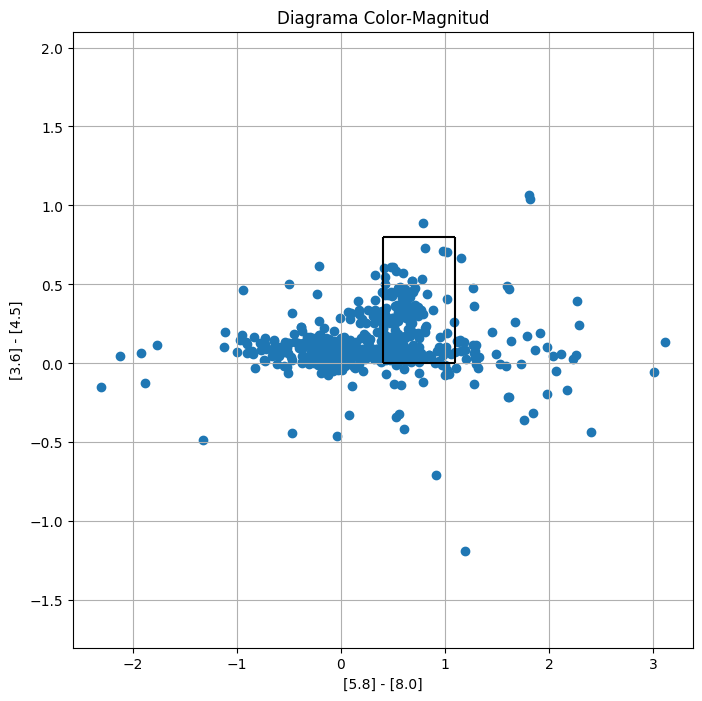

In [ ]:
'''
Se hace un match entre las gráficas utilizando TopCat filtrando el ID para tener solo las estrellas
que están en los 4 canales. Se grafican el diagrama color-magnitud.
'''

import matplotlib.pyplot as plt
import pandas as pd

tabla = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MatchTablaIDEC06.csv")
mag3_6 = tabla["1_mag_0"]
mag4_5 = tabla["2_mag_0"]
mag5_8 = tabla["3_mag_0"]
mag8_0 = tabla["4_mag_0"]

plt.figure(figsize=(8,8))
plt.scatter( mag5_8-mag8_0, mag3_6-mag4_5)
plt.ylabel('[3.6] - [4.5]')
plt.xlabel('[5.8] - [8.0]')
plt.title('Diagrama Color-Magnitud')
plt.grid(True)
plt.ylim(-1.8,2.1)

plt.hlines(0, 0.4, 1.1, 'k')
plt.hlines(0.8, 0.4, 1.1, 'k')
plt.vlines(0.4, 0, 0.8, 'k')
plt.vlines(1.1, 0, 0.8, 'k')

plt.show()